In [1]:
import numpy as np
import pandas as pd
import scipy as sc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import matplotlib as mpl
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from skimage import exposure
import numba
import umap
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from osgeo import gdal

In [3]:
from iic.datasets import SateliteDataset

In [30]:
BASE_DIR_LANDSAT = "data/portharcourt_images"
BASE_DIR_LANDCOVER = "data/portharcourt_images"

# Data preprocessing

In [3]:
EPS = 1e-16



def compute_NDVI(img, watermask=None, c=1, percentile=10):
    nir = img[:, :, :, 3]
    p_min, p_max = np.percentile(nir, (percentile, 100.0-percentile))
    nir = exposure.rescale_intensity(nir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

        
    red = img[:, :, :, 2]
    p_min, p_max = np.percentile(red, (percentile, 100.0-percentile))
    red = exposure.rescale_intensity(red, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))
    
    
    if watermask is not None:
        mask = watermask[:, :, :, 0] == 0
        red[mask] = 1-EPS 
        nir[mask] = EPS
    
    out = (nir - red)/(nir + red)

    p_min, p_max = np.percentile(out, (2, 100.0-2))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(-1, 1))
    return out[:, :, :, None]


def compute_NDBI(img, watermask=None, percentile=10):
    nir = img[:, :, :, 3]
    p_min, p_max = np.percentile(nir, (percentile, 100.0-percentile))
    nir = exposure.rescale_intensity(nir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

    swir = img[:, :, :, 4]
    p_min, p_max = np.percentile(swir, (percentile, 100.0-percentile))
    swir = exposure.rescale_intensity(swir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

    if watermask is not None:
        mask = watermask[:, :, :, 0] == 0
        nir[mask] = 1-EPS 
        swir[mask] = EPS

    out = ((swir - nir)/(swir + nir))
    p_min, p_max = np.percentile(out, (2, 100.0-2))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(-1, 1))
    return out[:, :, :, None]


def compute_BU(ndvi, ndbi, percentile=1):
    out = ndbi-ndvi
    p_min, p_max = np.percentile(out, (percentile, 100.0-percentile))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(0, 1))
    return out


def extract_water(img):
    p_min, p_max = np.percentile(img, (5, 95))
    img = exposure.rescale_intensity(img, in_range=(p_min, p_max), out_range=(0, 1))
    img = exposure.adjust_gamma(img, gamma=0.001)
    return img


def get_water_mask(image_data, percentile=5):
    waterbands = np.where((image_data== 21888.0) | (image_data == 21952.0), 0, 1)
    print(waterbands.shape)
    return waterbands[:, :, :, 7:8]

def compute_water_index(image_data, percentile=10):
    green = image_data[:,:,:,1]
    p_min, p_max = np.percentile(green, (percentile, 100.0-percentile))
    green = exposure.rescale_intensity(green, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

    swir1 = image_data[:,:,:,4]
    p_min, p_max = np.percentile(swir1, (percentile, 100.0-percentile))
    swir1 = exposure.rescale_intensity(swir1, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))

    out = (green - swir1) / (green + swir1)
    p_min, p_max = np.percentile(out, (percentile, 100.0-percentile))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(-1, 1))
    
    return out[:, :, :, None]

def compute_NDISI(image_data, percentile=10):
    tir1 = image_data[:,:,:,6]
    p_min, p_max = np.percentile(tir1, (percentile, 100.0-percentile))
    tir1 = exposure.rescale_intensity(tir1, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))
    tir1 = tir1[:,:,:,None]

    nir = image_data[:, :, :, 3]
    p_min, p_max = np.percentile(nir, (percentile, 100.0-percentile))
    nir = exposure.rescale_intensity(nir, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))
    nir = nir[:,:,:,None]

    swir1 = image_data[:,:,:,4]
    p_min, p_max = np.percentile(swir1, (percentile, 100.0-percentile))
    swir1 = exposure.rescale_intensity(swir1, in_range=(p_min, p_max), out_range=(0 + EPS, 1 - EPS))
    swir1 = swir1[:,:,:,None]
    
    wi = compute_water_index(image_data)

    out = (tir1 - ((wi+nir+swir1)/3)) / (tir1 + ((wi+nir+swir1)/3))
    p_min, p_max = np.percentile(out, (percentile, 100.0-percentile))
    out = exposure.rescale_intensity(out, in_range=(p_min, p_max), out_range=(-1, 1))

    return out

def normalize_band(img, band, percentile):
    p_min, p_max = np.percentile(img[:, :, :, band], (percentile, 100.0-percentile))
    img[:, :, :, band] = exposure.rescale_intensity(img[:, :, :, band], in_range=(p_min, p_max), out_range=(0, 1))

    return img


def normalize_percentile(image_data, percentile):
    for year in range(image_data.shape[0]):
        for ch in range(0, image_data.shape[-1]):
            image_data = normalize_band(image_data, ch, percentile)

    return image_data


def preprocess_data(image_data):


    image_data_p_1 = normalize_percentile(image_data.copy(), 2)
    waterbands = get_water_mask(image_data)
    ndvi_band = compute_NDVI(image_data.copy(), watermask=waterbands)
    ndbi_band = compute_NDBI(image_data.copy(), watermask=waterbands)
    bu_index = compute_BU(ndvi_band, ndbi_band)
    ndisi_band = compute_NDISI(image_data.copy())
    water_index = compute_water_index(image_data.copy())

  
    img_out = np.concatenate([image_data_p_1, waterbands, ndvi_band, ndbi_band, bu_index, water_index, ndisi_band], axis=-1)
    return img_out


# Method Definitions

In [4]:
def load_satelite_image(path):
  img = np.load(path)
  img = img.transpose(0, 2, 3, 1) # year, lat, lon, band
  for year in range(img.shape[0]):
    t_year = img[year]
    pos_inf = t_year[np.isfinite(t_year)].max()
    neg_inf = t_year[np.isfinite(t_year)].min()
    t_year = np.nan_to_num(t_year, nan=0.0, posinf=pos_inf, neginf=neg_inf)
    np.where(np.abs(t_year) >= 2, np.median(t_year), t_year)
    img[year] = t_year
  return img

def plot_all_bands(img_mat, year, year_name=2013, band_title_map=None):
    columns = int(np.ceil(np.sqrt(img_mat.shape[-1])))
    rows = int(np.ceil(np.sqrt(img_mat.shape[-1])))
    print(columns*rows, img_mat.shape[-1])
    fig = plt.figure(figsize=(5*columns, 5*rows))
    for i in range(1, img_mat.shape[-1]+1):
        img = img_mat[year, :, :, i-1]
        ax = fig.add_subplot(rows, columns, i)
        aa = ax.matshow(img)
        fig.colorbar(aa, ax=ax)
        if band_title_map is None:
          ax.set_title(f"Band {i-1}")
        else:
          ax.set_title(band_title_map[i-1])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    #fig.suptitle(f"Year: {year_name}"
    plt.show()

def get_silhouette(labels, image):
    for i, k in enumerate(range(2, 8)):
       
        bisecting = BisectingKMeans(n_clusters=k, random_state=420)
        labels = bisecting.fit_predict(image)

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        
        silhouette = silhouette_samples(image, labels)
        
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            
            cluster_silhouette_vals = silhouette[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02)

    return silhouette

def cluster_kmeans(k, image):
    kmeans = KMeans(n_clusters=k, random_state=420).fit(image)

    return kmeans

def cluster_bisecting_kmeans(k, image):
    bisecting = BisectingKMeans(n_clusters=k, random_state=420)
    labels = bisecting.fit_predict(image)
    return bisecting, labels

def cluster_spectral(k, image):
    spectral = SpectralClustering(n_clusters=k, random_state=420).fit(image)

    return spectral

def cluster_dbscan(eps, min_samples, image):
   dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm="ball_tree", metric="manhattan").fit(image)

   return dbscan

def cluster_optics(max_eps, min_samples, image):
   optics = OPTICS(max_eps=max_eps, min_samples=min_samples, xi=0.008).fit(image)

   return optics

def map_kmeans(k, kmeans_data, image_map, data_indices, title="Kmeans"):
    idx = np.argsort(kmeans_data.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(k)

    for i, (rows, cols) in enumerate(data_indices):
        image_map[:, rows, cols] = lut[kmeans_data.labels_[i]] + 1

    plt.matshow(LABELS)
    plt.colorbar()
    plt.title("Ground Truth")
    plt.show()

    plt.matshow(image_map[0, :, :], cmap=mpl.colormaps['turbo'])
    plt.colorbar()
    plt.title(title)
    plt.show()

def map_optics(optics_data, image_map, data_indices, title="Optics"):
    # idx = np.argsort(optics_data.cluster_centers_.sum(axis=1))
    # lut = np.zeros_like(idx)
    # lut[idx] = np.arange(k)

    for i, (rows, cols) in enumerate(data_indices):
        image_map[:, rows, cols] = optics_data.labels_[i]

    plt.matshow(LABELS)
    plt.colorbar()
    plt.title("Ground Truth")
    plt.show()

    plt.matshow(image_map[0, :, :], cmap=mpl.colormaps['turbo'])
    plt.colorbar()
    plt.title(title)
    plt.show()

def raster_download (file_name, raster):

    ds = gdal.Open(f"{BASE_DIR_LANDSAT}/image_2020.tif")
    band = ds.GetRasterBand(2)
    arr = raster
    [cols, rows] = arr.shape
    print(arr.shape)
    format = "GTiff"
    driver = gdal.GetDriverByName(format)


    outDataRaster = driver.Create(f"{BASE_DIR_LANDSAT}/{file_name}", rows, cols, 1, gdal.GDT_Float32)
    outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
    outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


    outDataRaster.GetRasterBand(1).WriteArray(raster)

    outDataRaster.FlushCache() ## remove from memory
    del outDataRaster ## delete the data (not the actual geotiff)

In [7]:
PANCHROMATIC = load_satelite_image("data/nairobi_images_summer_raw/data_raw.npy")

PANCHROMATIC = normalize_percentile(PANCHROMATIC.copy(), 2)
PANCHROMATIC = PANCHROMATIC[:8, :, :, -1, None]

print(PANCHROMATIC.shape)

(8, 665, 665, 1)


In [31]:
IMAGE_RAW = load_satelite_image(f"{BASE_DIR_LANDSAT}/data_raw.npy") # year, lat, lon, band

IMAGE_RAW = preprocess_data(IMAGE_RAW)
#IMAGE_RAW = np.append(IMAGE_RAW, PANCHROMATIC, axis=3)

BANDS = IMAGE_RAW.shape[-1]


LABELS = np.load(f"{BASE_DIR_LANDCOVER}/worldcover_adj_classes.npy")
print(IMAGE_RAW.shape)
print(LABELS.shape)

(9, 666, 666, 8)
(9, 666, 666, 14)
(666, 666)


(array([10, 40, 50, 80], dtype=uint8), array([232144,  13434, 134259,  63719]))
16 14


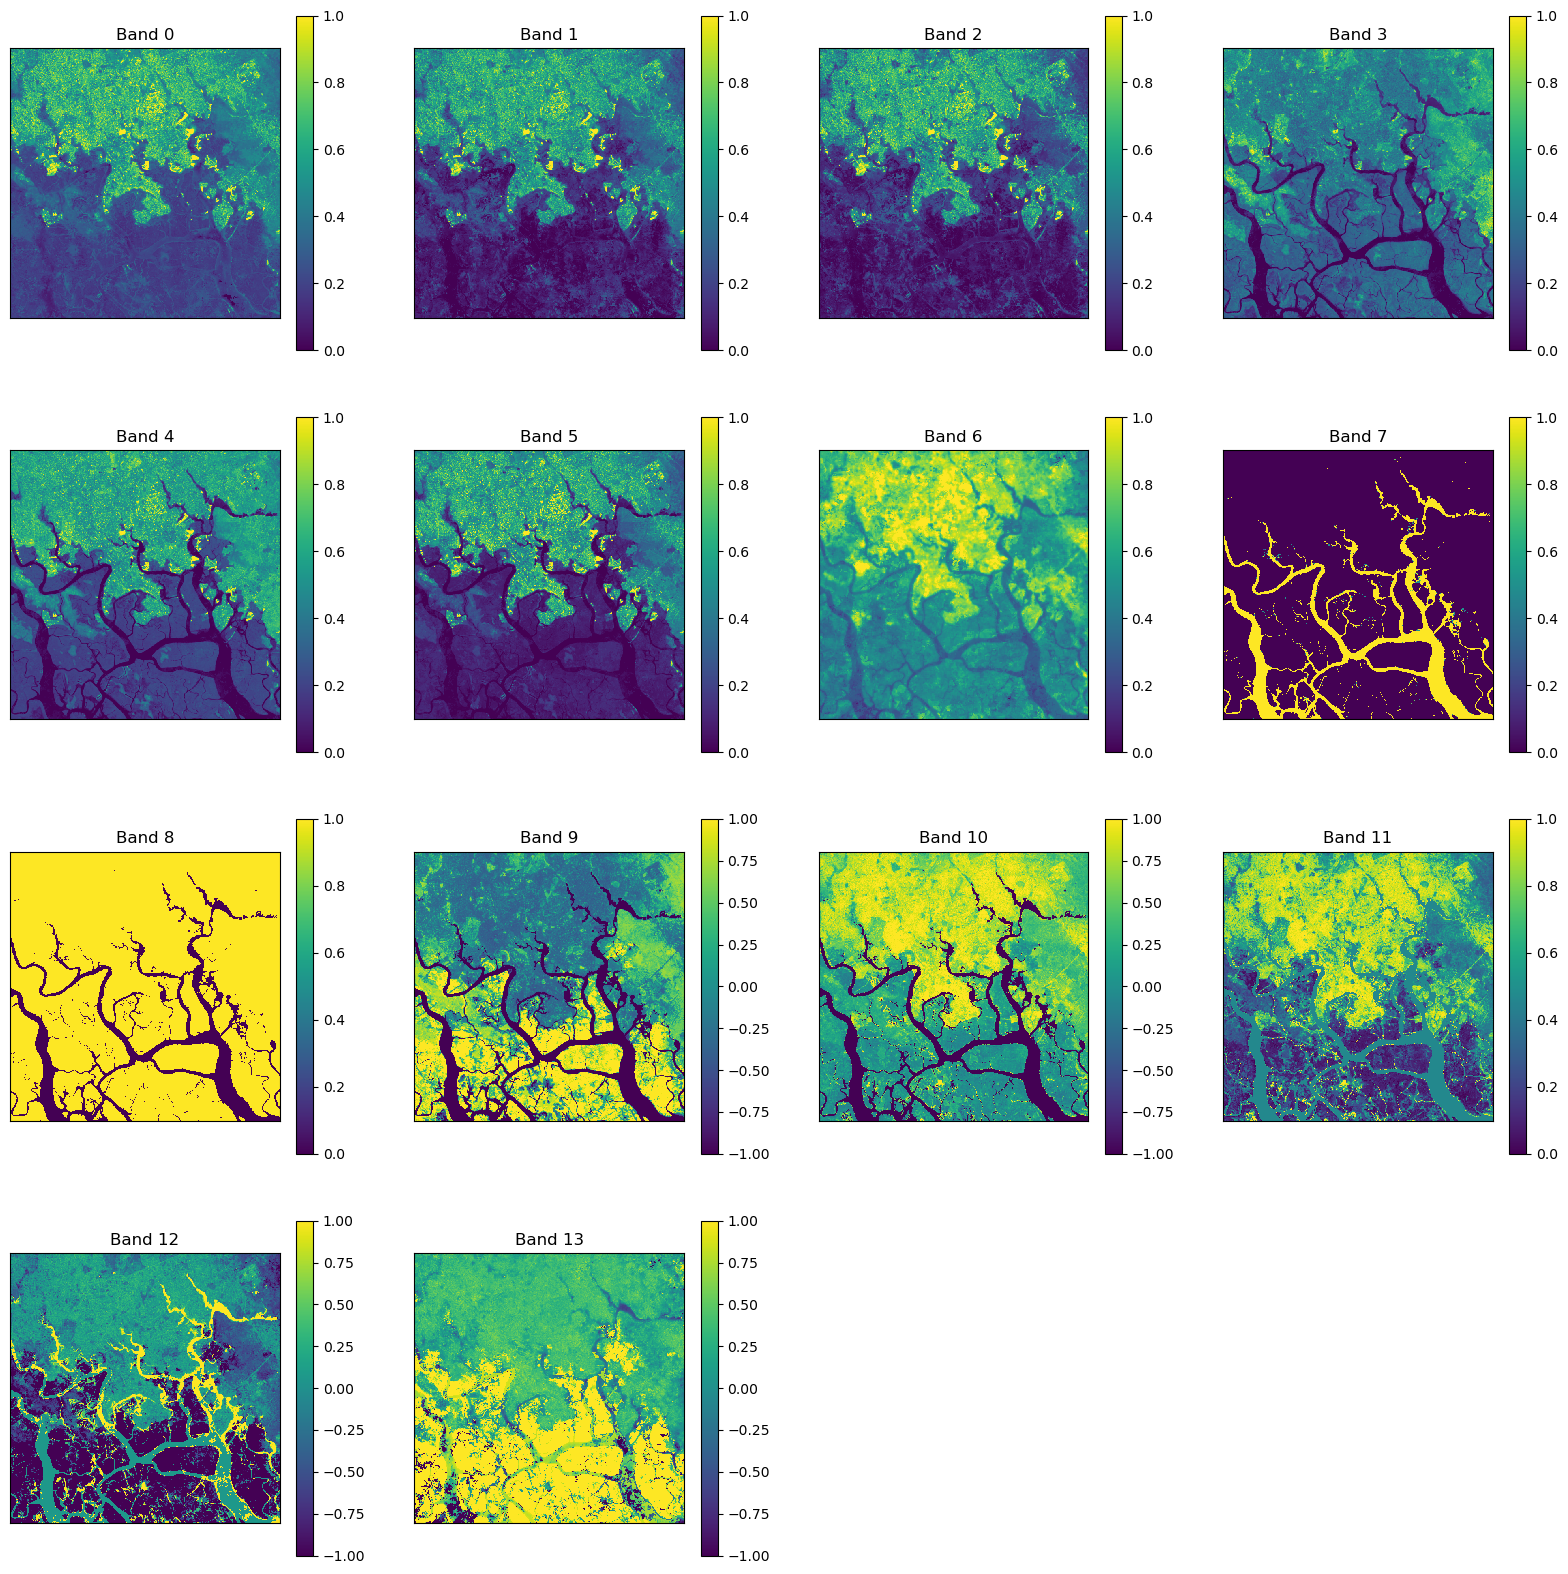

In [32]:
print(np.unique(LABELS, return_counts=True))
plot_all_bands(IMAGE_RAW[:, :, :, :], -1)

In [12]:
raster_download('kampala_mndwi.tif', IMAGE_RAW[-1, :, :, 12])
raster_download('kampala_ndisi.tif', IMAGE_RAW[-1, :, :, 13])

(664, 664)
(664, 664)


Warning 1: PROJ: proj_create_from_database: Open of /home/mendozaemir/anaconda3/envs/remote-sensing-landuse/share/proj failed
Warning 1: The definition of projected CRS EPSG:32636 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
ERROR 1: PROJ: proj_create_from_name: Open of /home/mendozaemir/anaconda3/envs/remote-sensing-landuse/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/mendozaemir/anaconda3/envs/remote-sensing-landuse/share/proj failed
Warning 1: The definition of projected CRS EPSG:32636 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official par

# Prepare data for Clustering

In [6]:
BANDS_USED = [0, 1, 2, 3, 4, 5, 9, 10, 11]
BLANK_INDICES_ROWS, BLANK_INDICES_COLS = np.where(LABELS != 50)

IMAGE_MAP = IMAGE_RAW[-2, :, :, BANDS_USED]
print(IMAGE_MAP.shape)

for i, j in zip(BLANK_INDICES_ROWS, BLANK_INDICES_COLS):
    IMAGE_MAP[:, i, j] = np.nan

BUILD_INDICES_ROWS, BUILD_INDICES_COLS = np.where(LABELS == 50)

IMAGE_BUILD = IMAGE_RAW[-2,  LABELS == 50, :]
IMAGE_UMAP = IMAGE_BUILD[:, BANDS_USED]
print(IMAGE_UMAP.shape)

(9, 665, 665)
(81915, 9)


# Downprojection with UMAP

In [13]:
#Used to check for correlation of data before actually clustering

# weight_matrix = np.asarray([
#     [1.0, 1.0, 1.0],
#     [1.0, 20.0, 1.0],
#     [1.0, 1.0, 1.0]
# ])

# weight_matrix = np.dstack([weight_matrix]*len(BANDS_USED))

# @numba.njit()
# def sparse_eucliden_dist(a, b):
#     a = a.reshape(3, 3, len(BANDS_USED))
#     b = b.reshape(3, 3, len(BANDS_USED))
#     dist = ((a-b)*weight_matrix).flatten()
#     return np.linalg.norm((dist).flatten(), 1)

# u = umap.UMAP(n_neighbors=30,
#                 min_dist=0.1,
#                       metric='euclidean').fit_transform(IMAGE_UMAP)

# print(u.shape)

# plt.scatter(u[:, 0], u[:, 1])
# plt.legend()
# plt.show()

# Clustering with KMeans

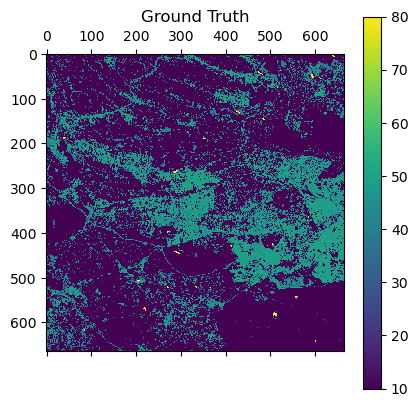

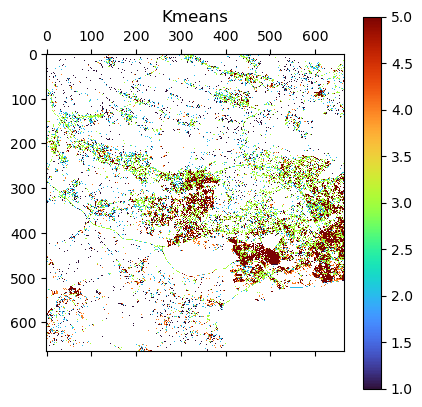

In [7]:
k=5
kmeans, labels = cluster_bisecting_kmeans(k, IMAGE_UMAP)
map_kmeans(k, kmeans, IMAGE_MAP, zip(BUILD_INDICES_ROWS, BUILD_INDICES_COLS))

[0 1 2 3 4]
before silhouette
after silhouette
test
test
before silhouette
after silhouette
test
test
test
before silhouette
after silhouette
test
test
test
test
before silhouette
after silhouette
test
test
test
test
test
before silhouette
after silhouette
test
test
test
test
test
test
before silhouette
after silhouette
test
test
test
test
test
test
test


array([0.16688284, 0.16688284, 0.16688284, ..., 0.3750201 , 0.31967812,
       0.17475181])

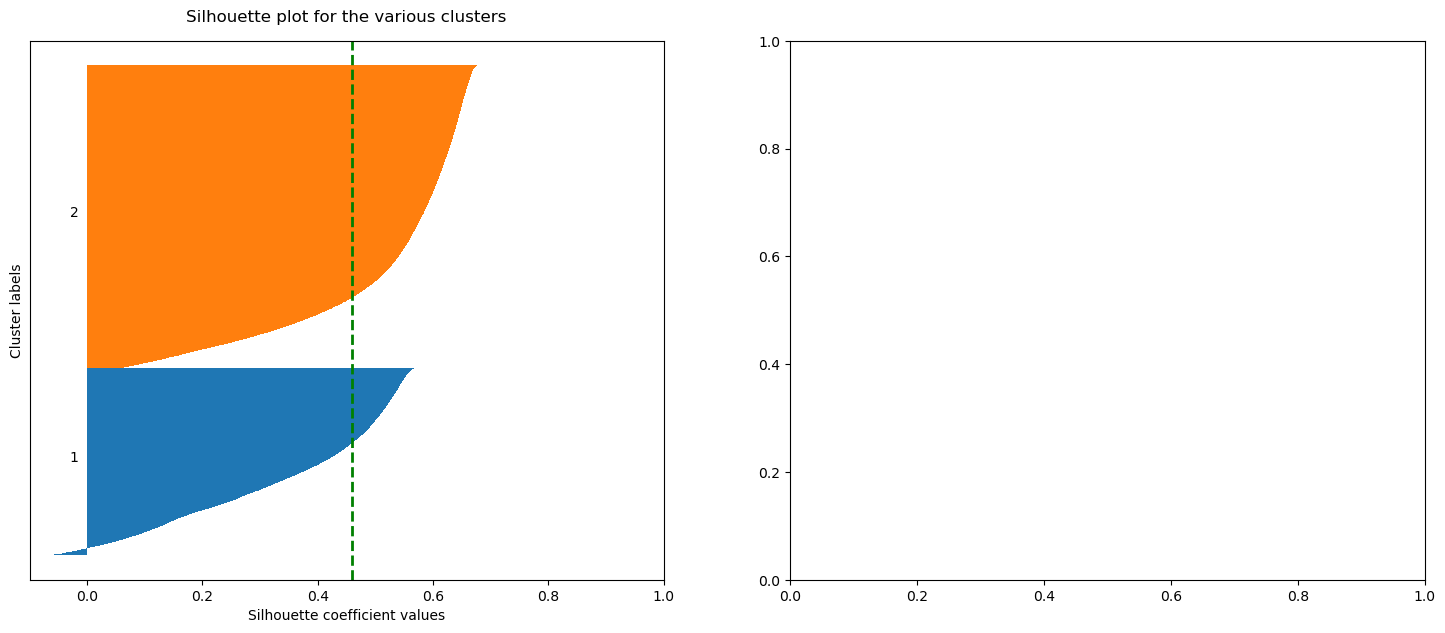

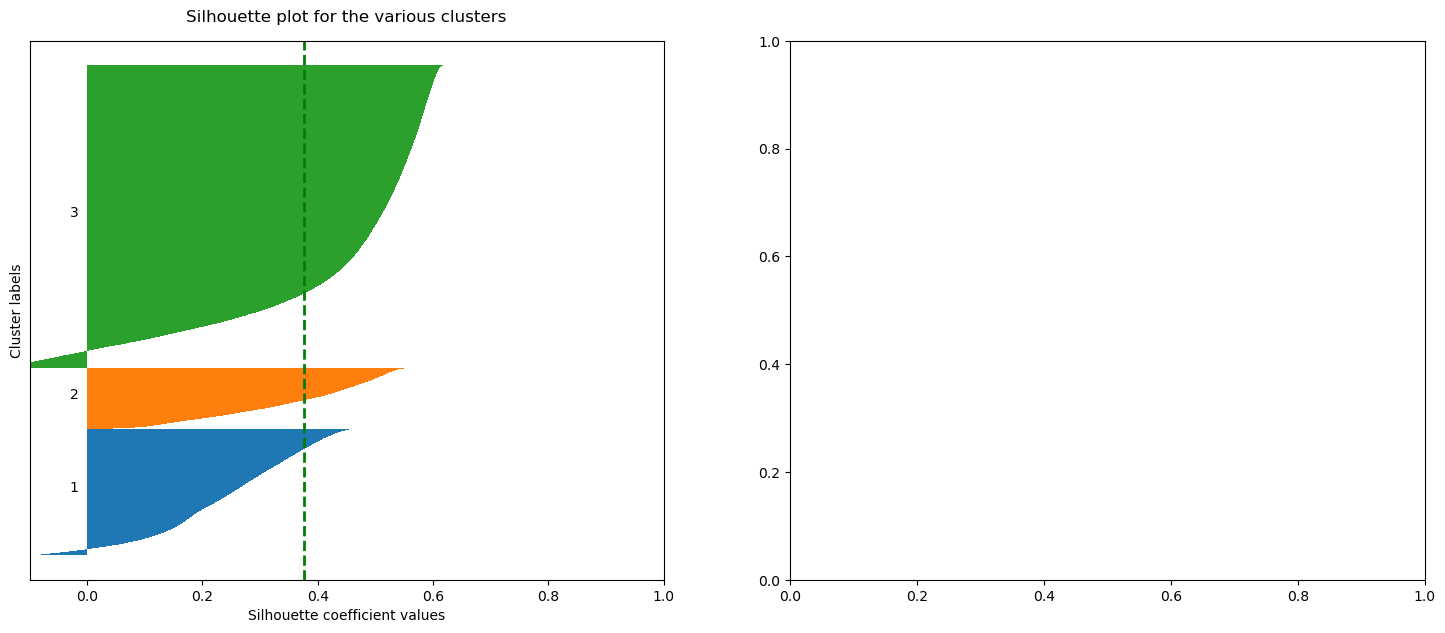

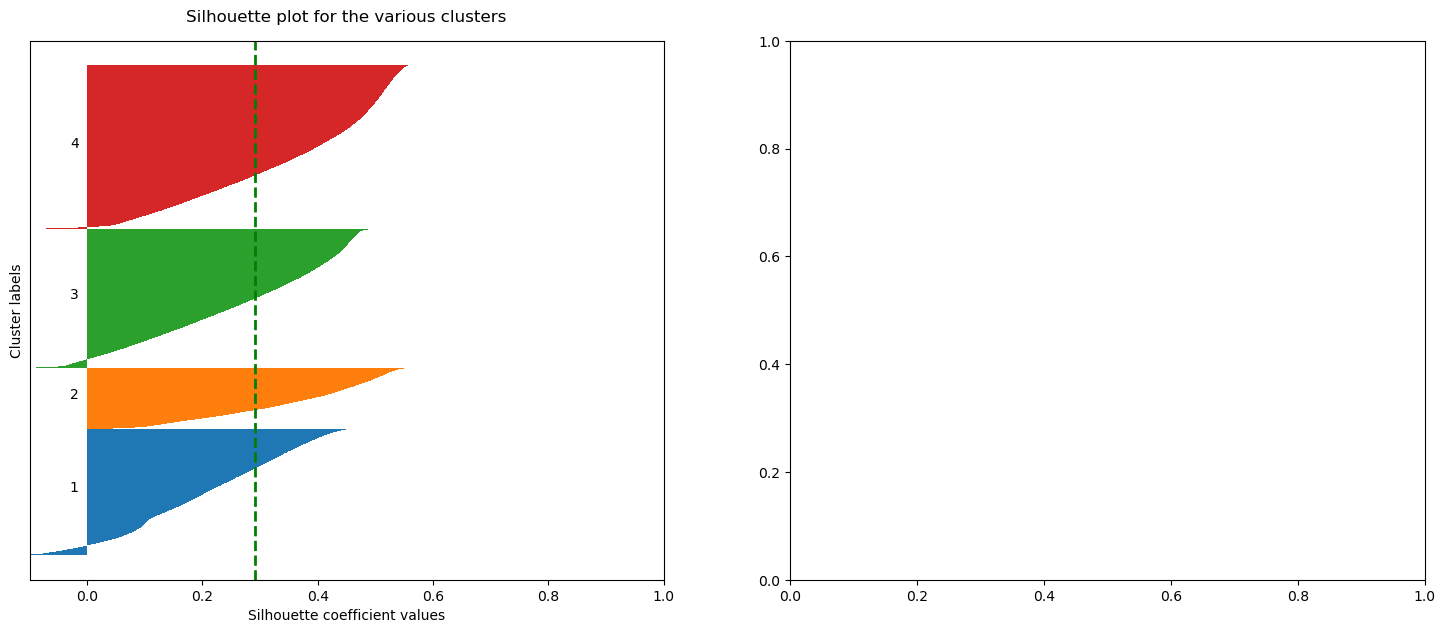

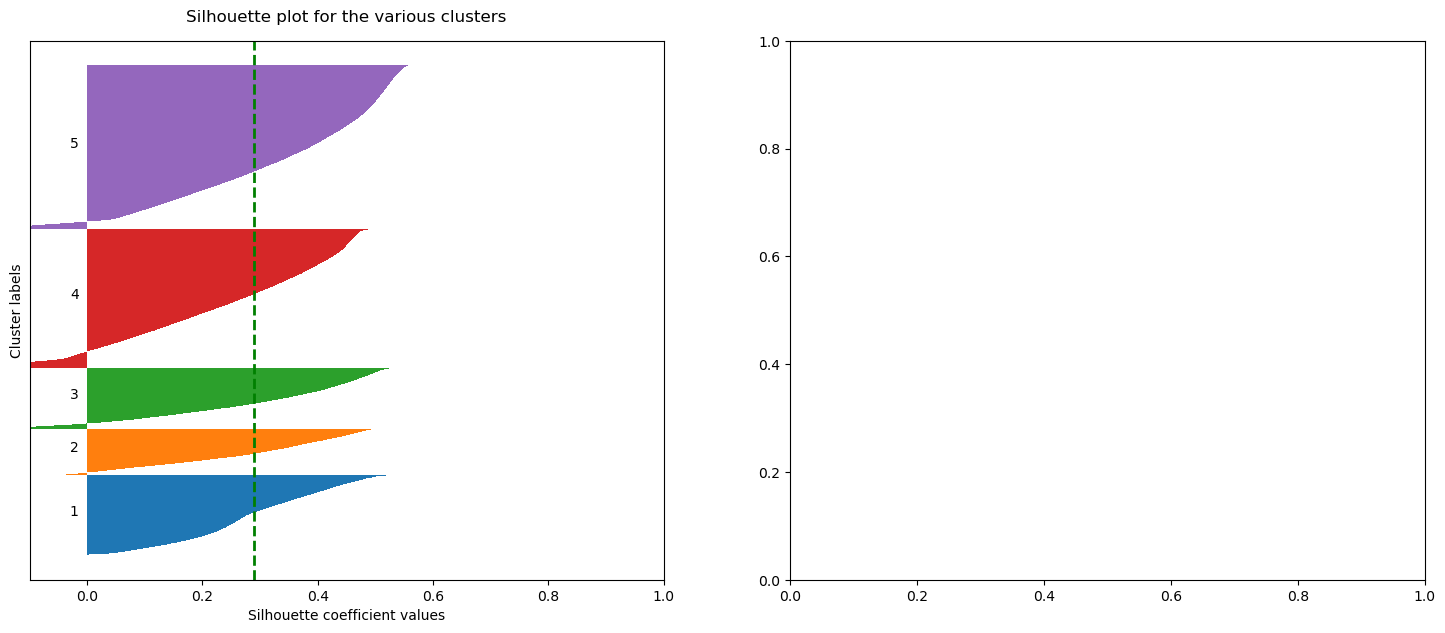

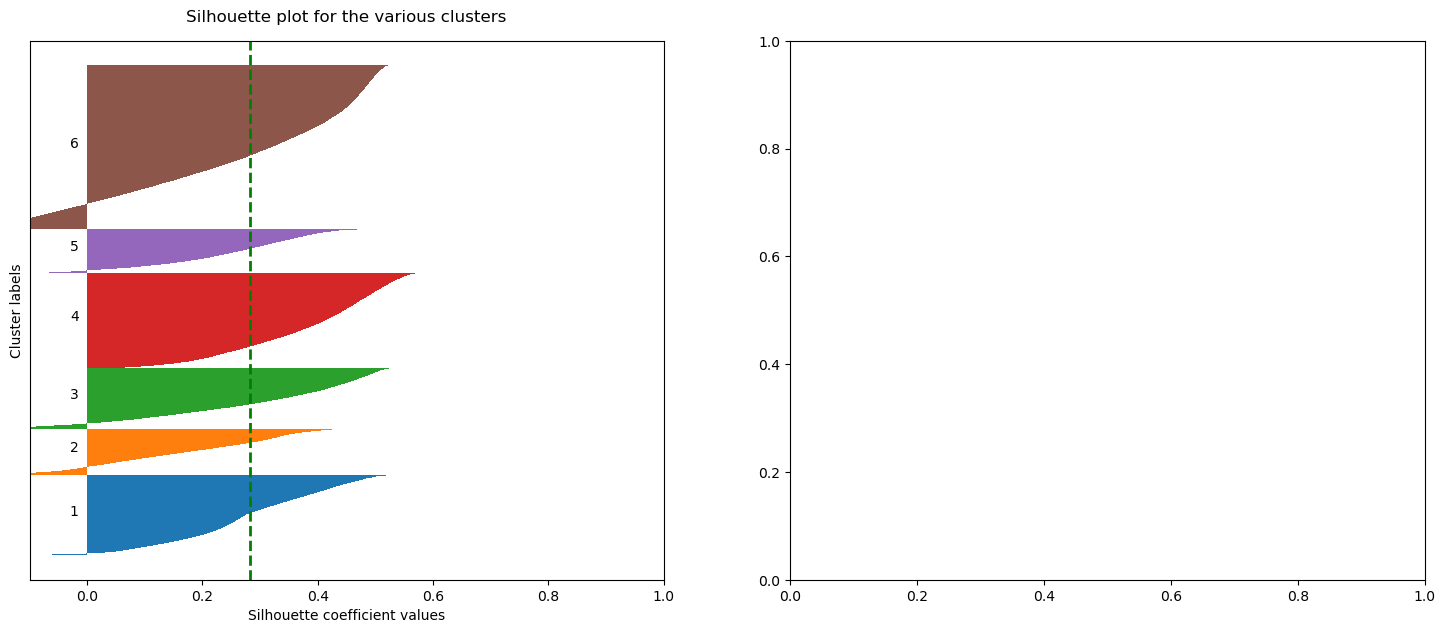

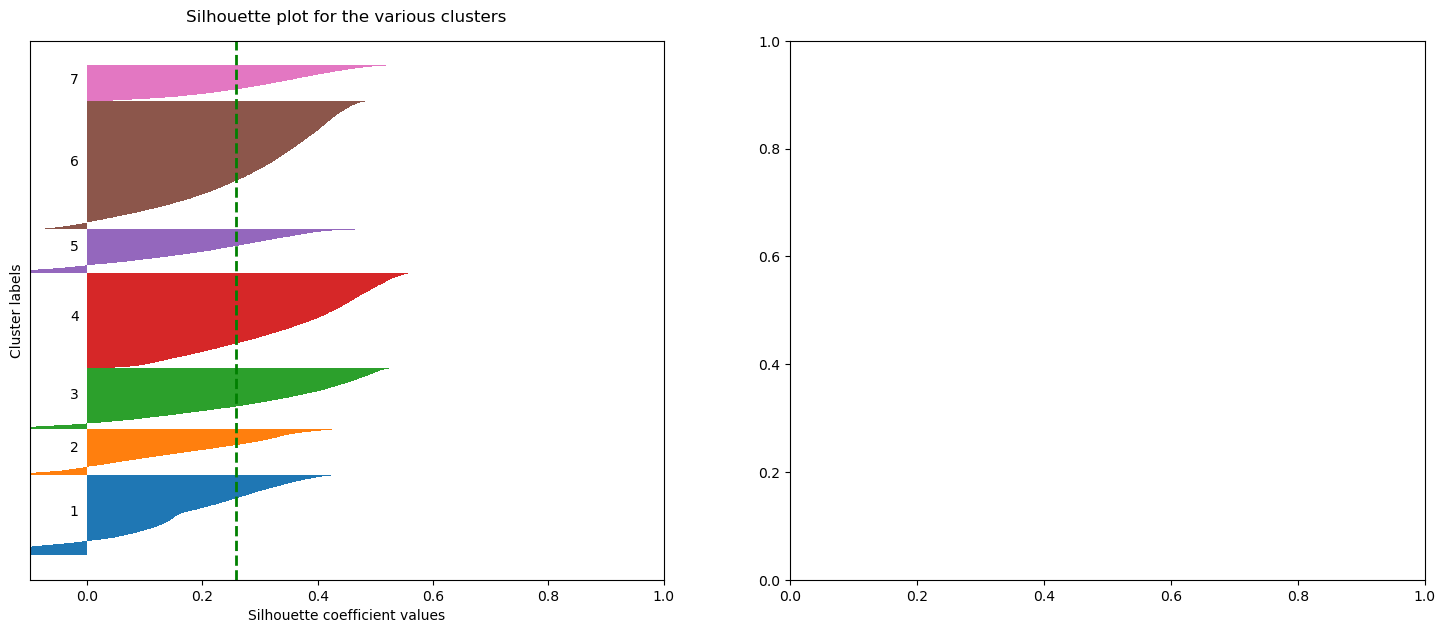

In [11]:
print(np.unique(labels))
get_silhouette(labels, IMAGE_UMAP)

In [15]:
raster_download('bisecting_5.tif', IMAGE_MAP[0, : ,:])

(670, 670)


# Clustering Kmeans on only the "Slum Cluster"

In [15]:
largest_cluster = np.max(kmeans.labels_)
print(largest_cluster)
IMAGE_MAP_SLUM = IMAGE_MAP
NON_SLUM_INDICES_ROWS, NON_SLUM_INDICES_COLS = np.where(IMAGE_MAP_SLUM[0, :, :] != largest_cluster)
print(np.array(NON_SLUM_INDICES_ROWS).shape)

for i, j in zip(NON_SLUM_INDICES_ROWS, NON_SLUM_INDICES_COLS):
    IMAGE_MAP_SLUM[:, i, j] = np.nan

SLUM_INDICES_ROWS, SLUM_INDICES_COLS = np.where(IMAGE_MAP_SLUM[0, :, :] == largest_cluster)
SLUM_INDICES = zip(SLUM_INDICES_ROWS, SLUM_INDICES_COLS)
print(np.array(SLUM_INDICES_ROWS).shape)

IMAGE_SLUMS = IMAGE_RAW[-2, IMAGE_MAP_SLUM[0, :, :] == largest_cluster, :]
IMAGE_SLUMS = IMAGE_SLUMS[:, BANDS_USED]

print(IMAGE_SLUMS.shape)

4
(397862,)
(44363,)
(44363, 9)


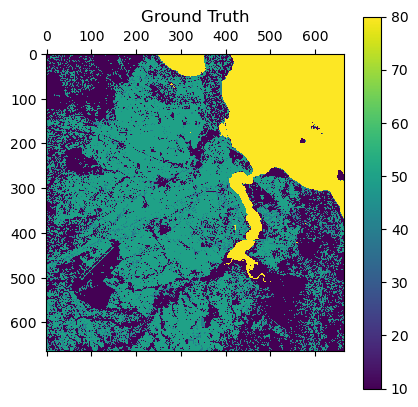

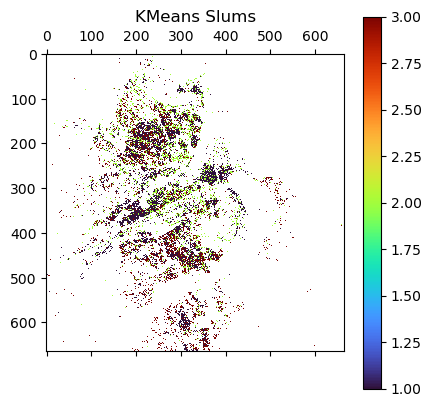

In [16]:
k=3
kmeans_slums = cluster_bisecting_kmeans(k, IMAGE_SLUMS)
map_kmeans(k, kmeans_slums, IMAGE_MAP_SLUM, SLUM_INDICES, "KMeans Slums")

In [17]:
raster_download('bisecting_3_slum.tif', IMAGE_MAP_SLUM[0, : ,:])

(665, 665)


# Cluster further

In [32]:
largest_cluster = np.max(kmeans_slums.labels_)
print(largest_cluster)
IMAGE_MAP_SLUM_2 = IMAGE_MAP_SLUM
NON_SLUM_INDICES_ROWS, NON_SLUM_INDICES_COLS = np.where(IMAGE_MAP_SLUM_2[0, :, :] != largest_cluster)
print(np.array(NON_SLUM_INDICES_ROWS).shape)

for i, j in zip(NON_SLUM_INDICES_ROWS, NON_SLUM_INDICES_COLS):
    IMAGE_MAP_SLUM_2[:, i, j] = np.nan

SLUM_INDICES_ROWS, SLUM_INDICES_COLS = np.where(IMAGE_MAP_SLUM_2[0, :, :] == largest_cluster)
SLUM_INDICES = zip(SLUM_INDICES_ROWS, SLUM_INDICES_COLS)
print(np.array(SLUM_INDICES_ROWS).shape)

IMAGE_SLUMS_2 = IMAGE_RAW[-2, IMAGE_MAP_SLUM_2[0, :, :] == largest_cluster, :]
IMAGE_SLUMS_2 = IMAGE_SLUMS_2[:, BANDS_USED]

print(IMAGE_SLUMS_2.shape)

1
(421508,)
(20717,)
(20717, 10)


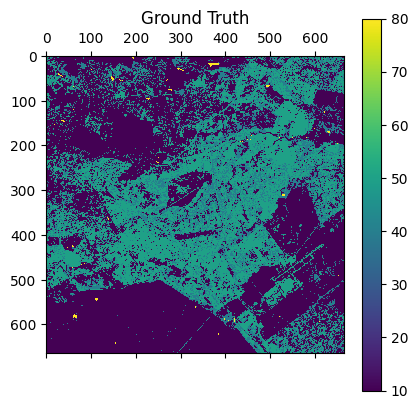

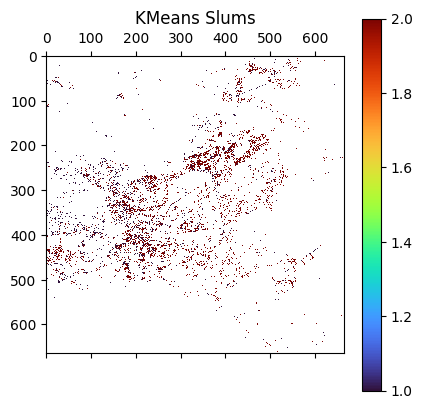

In [33]:
k=2
kmeans_slums_2 = cluster_bisecting_kmeans(k, IMAGE_SLUMS_2)
map_kmeans(k, kmeans_slums_2, IMAGE_MAP_SLUM_2, SLUM_INDICES, "KMeans Slums")

# Clustering using IIC

In [67]:
CUT_OFF = 10
TRAIN_IMAGE = IMAGE_RAW[0:-1, CUT_OFF:-CUT_OFF, CUT_OFF:-CUT_OFF, BANDS_USED]
IMAGE = IMAGE_RAW[-2:-1, CUT_OFF:-CUT_OFF, CUT_OFF:-CUT_OFF, BANDS_USED]
LABELS = LABELS[CUT_OFF:-CUT_OFF, CUT_OFF:-CUT_OFF]
BANDS = TRAIN_IMAGE.shape[-1]

print(TRAIN_IMAGE.shape, IMAGE.shape, LABELS.shape)

(8, 645, 645, 9) (1, 645, 645, 9) (645, 645)


torch.Size([12800, 9, 16, 16]) torch.Size([1600, 9, 16, 16])


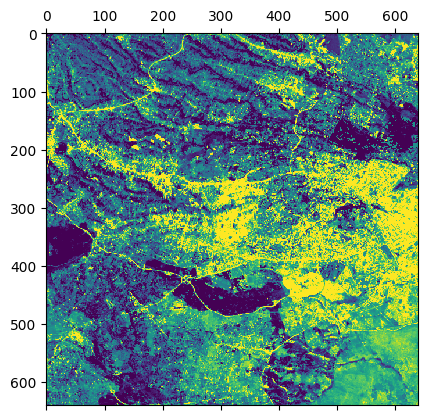

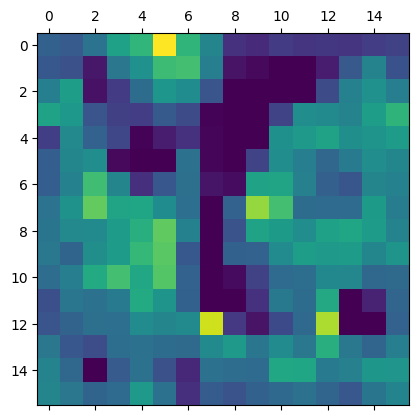

torch.Size([12800, 9, 16, 16])


In [69]:
from iic.datasets import SateliteDataset
from iic.transforms import RandomVFlipTransformIIC, RandomHFlipTransformIIC
from iic.models import IICModel
from utils.data_preprocessing import segment_satelite_image, recombine_image



def create_image_dataset(image, sub_image_size):
    """
    Given a series of images: (Y, W, H, CH) create a dataset:
    (B, ch, sub_image, sub_imahe, )
    """
    ds = []
    recombination_size = None
    for year in range(image.shape[0]):
        img_ = image[0].transpose(2, 0, 1)
        seg_images, recombination_size_ = segment_satelite_image(img_, sub_size=sub_image_size)
        
        recombination_size = recombination_size_
        ground_truth = img_[:, :recombination_size[0]*sub_image_size, :recombination_size[1]*sub_image_size]
        assert np.allclose(ground_truth, recombine_image(seg_images, recombination_size_, sub_image_size).numpy())
        assert recombination_size is None or recombination_size_ == recombination_size
        
        ds.append(seg_images)
    return torch.concat(ds), recombination_size

SUB_IMAGE_SIZE = 16
CROP_FACTOR = 1.0


TRAIN_DATA, RECOMBINATION_SIZE = create_image_dataset(TRAIN_IMAGE, SUB_IMAGE_SIZE)
VALIDATION_DATA, _ = create_image_dataset(IMAGE, SUB_IMAGE_SIZE)
print(TRAIN_DATA.shape, VALIDATION_DATA.shape)

validation_rec = recombine_image(VALIDATION_DATA, RECOMBINATION_SIZE, SUB_IMAGE_SIZE).numpy()
plt.matshow(validation_rec[-1])
plt.show()

plt.matshow(TRAIN_DATA[0, -1])
plt.show()

print(TRAIN_DATA.shape)

torch.Size([1, 9, 16, 16])
torch.Size([1, 9, 16, 16])
12800 1600


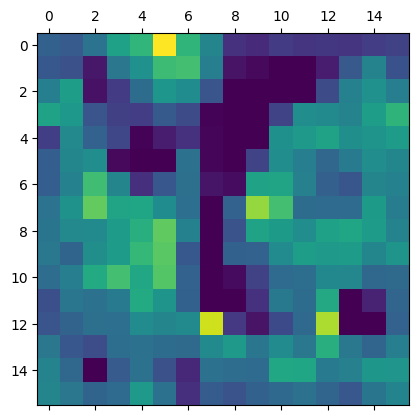

In [70]:
train_set = SateliteDataset(TRAIN_DATA, invariant_transforms=[RandomVFlipTransformIIC(0.5), RandomHFlipTransformIIC(0.5)])
val_set = SateliteDataset(VALIDATION_DATA, invariant_transforms=[])

# train_size = int(len(train_set)*0.9)
# val_size = len(train_set) - train_size
print(train_set[0:1]["img1"].shape)
print(train_set[0:1]["img2"].shape)
print(len(train_set), len(val_set))

plt.matshow(train_set[0:1]["img1"][0, -1])
plt.show()

In [59]:
model = IICModel(BANDS, 4, int(SUB_IMAGE_SIZE*CROP_FACTOR))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, num_workers=2)


trainer = pl.Trainer(max_epochs=10, devices=1)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type     | Params
----------------------------------
0 | net  | VGGTrunk | 21.1 K
----------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TODO tune hyperparams on big device

(31, 31)
(496, 496)
(496, 496)


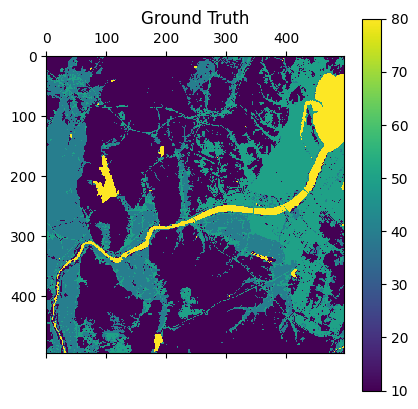

Traceback (most recent call last):
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/Users/davidwinderl/miniconda/envs/remote-sensing-landuse/lib/python3.8/multiprocess

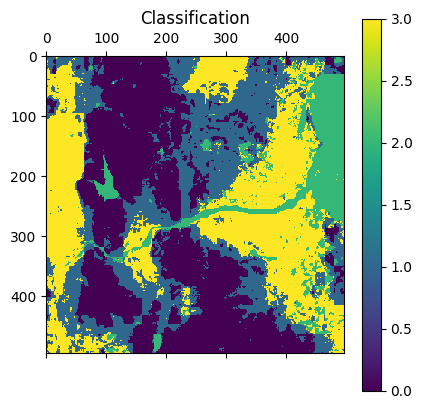

In [62]:
model = model.cpu()

SEG_IMAGE_OUT, RECOMBINATION_SIZE_OUT = segment_satelite_image(IMAGE, sub_size=int(SUB_IMAGE_SIZE*CROP_FACTOR))
print(RECOMBINATION_SIZE_OUT)
#VALIDATION_SET
sample_clf = model(val_set[0:]["img1"]).detach()
#sample_clf = model(SEG_IMAGE_OUT).detach()
sample_clf = recombine_image(sample_clf, RECOMBINATION_SIZE_OUT, int(SUB_IMAGE_SIZE*CROP_FACTOR))

test_classification = torch.argmax(sample_clf, axis=0).detach().numpy()

ground_truth_label = LABELS[:RECOMBINATION_SIZE_OUT[0]*int(SUB_IMAGE_SIZE*CROP_FACTOR), :RECOMBINATION_SIZE_OUT[1]*int(SUB_IMAGE_SIZE*CROP_FACTOR)]
print(ground_truth_label.shape)
print(test_classification.shape)

plt.matshow(ground_truth_label)
plt.colorbar()
plt.title("Ground Truth")
plt.show()

plt.matshow(test_classification)
plt.colorbar()
plt.title("Classification")
plt.show()